The snippet below contains a small two line initialization of the OpenCL internals required to identify the device on which the simulations should run. For simulations being run on personal workstations, this will be sufficient and can be safely copied and pasted into any RAMP script.

In [1]:
import mcramp as mcr
import pyopencl as cl
import numpy as np

ctx = cl.create_some_context()
queue = cl.CommandQueue(ctx)

In [2]:
# Physical constants

h=6.62607015e-34
mn=1.674929e-27
meV=1.602176634e-22
overAA = 1e10

Ei = 9.09 # meV - 3AA neutrons
Li = h / np.sqrt(2*mn*Ei*meV) * overAA
Mono_d_spacing = 3.355 # AA
Mono_angle = np.arcsin(Li / (2 * Mono_d_spacing))

The instrument definition file also contains the variable `detector_binning` which we can use to vary the histogram bins in the detector output.

In [3]:
detector_binning = [-40.0, 1.0, 140.0]

Instruments in RAMP are represented by the `Instrument` class, which contains the methods responsible for instantiating, simulating, and obtaining the results of simulations. Instances of the Instrument class are instantiated as follows:

In [4]:
inst = mcr.Instrument(
    'powder.json', 
    ctx, 
    queue, 
    Ei=Ei, 
    Mono_angle=Mono_angle, 
    detector_binning=detector_binning
)

C:\Users\wyz83832\AppData\Local\Continuum\anaconda3\lib\site-packages\pyopencl\__init__.py:235: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


The constructor for the `Instrument` class takes three arguments by default: the filename of the instrument definition file, the OpenCL context, and the OpenCL queue (the internals we set up earlier). The additional keyword arguments `Ei` and `Mono_angle` correspond to variables in the instrument definition file.

### Executing simulations

Simulations are executed by calling the `execute(N)` method of the `Instrument` class, where the argument `N` is the desired number of neutron histories to be simulated.

In [5]:
N = int(1e7)
inst.execute(N)

### Analysing simulation results

The easiest way to get a quick visual confirmation that a simulation has returned sensible results is by plotting the output of the instrument monitors using the `plot()` method of the `Instrument` class. This will do some default plotting using `matplotlib` of the histograms of all the detectors in the instrument.

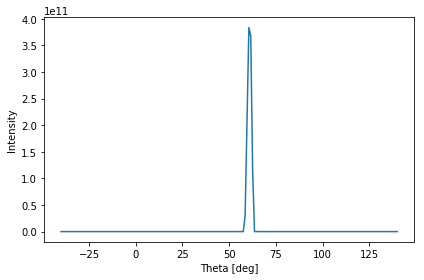

In [6]:
inst.plot()

We can see that there is a peak at approximately 60 degrees. Let's adjust the detector binning and re-run the simulation to obtain a better view of the peak shape.

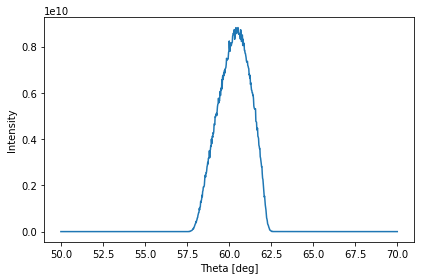

In [7]:
detector_binning = [50.0, 0.02, 70.0]
inst = mcr.Instrument(
    'powder.json', 
    ctx, 
    queue, 
    Ei=Ei, 
    Mono_angle=Mono_angle, 
    detector_binning=detector_binning
)
N = int(1e7)
inst.execute(N)
inst.plot()

Pretty ugly, but not surprising for such a crude instrument. To perform a more detailed analysis of the detector output, we can obtain the histogram using the `data()` method of the `Instrument` class. This method returns a dictionary whose keys are the names of components in the instrument definition and whose values are data produced by the corresponding component. Typically this will be non-zero for detectors which provide their axes and histogrammed intensities.

In [8]:
data = inst.data()
detector_output = data['Detector']
theta_axis = detector_output[0]
intensity = detector_output[1]

With this data in hand, we can now perform some analysis. To find the peak centre, let's naievely fit our lineshape to a Gaussian distribution and find the position of the mean.

In [9]:
from scipy.optimize import curve_fit

func = lambda x, c, mu, sigma: c*np.exp(-(x - mu)**2 / (2*sigma**2))
popt, pcov = curve_fit(func, xdata=theta_axis, ydata=intensity, p0=[1e10, 60.0, 2.5])
print(popt)

[8.84435273e+09 6.03711688e+01 1.02435847e+00]


Giving a peak center of 60.4 degrees (as compared to the nominal answer of 60 degrees exactly for our chosen sample and instrument parameters). Plotting the resulting fit yields...

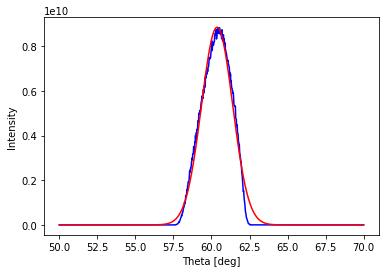

In [10]:
import matplotlib.pyplot as plt

plt.plot(theta_axis, intensity, 'b-')
plt.plot(theta_axis, func(theta_axis, *popt), 'r-')
plt.ylabel("Intensity")
plt.xlabel("Theta [deg]")
plt.show()

To save the results of a simulation for analysis at a later date, the `Instrument` class provides the `save()` method. Any component with a `filename` argument will save it's `data()` output as a numpy file `filename.npy` when `inst.save()` is  called.

## Instrument class reference